### Author: Hoang Chu

#### Imports

In [569]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import requests

In [570]:
import importlib
import helper, consts

In [571]:
importlib.reload(consts)
importlib.reload(helper)

<module 'helper' from 'c:\\Users\\hoang\\OneDrive\\Desktop\\Clinic\\code\\helper.py'>

#### CONSTANTS

In [572]:
ROW_AX = 0
COL_AX = 1

In [573]:
DATA_PATH = consts.DATA_PATH
DATA_PATH

'../data/'

In [574]:
RESPONSE_NAME = "rel2retcfrtxm_nt_0"
PREDICTOR_NAME = 'rrirpnxm_nt_0'

#### Data Exploration

In [575]:
# local read

data_20191202_1200_df = pd.read_csv(DATA_PATH + "data_20191202_1200.csv")

In [576]:
# cloud read -- TODO: NEED A PERMANET LINK!!

# importlib.reload(consts)

# url = ... # url in consts.py
# assert requests.get(url).status_code == 200
# data_20191202_1200_df = pd.read_csv(url)
# data_20191202_1200_df.head()

In [577]:
working_df = data_20191202_1200_df.copy() # Deep copy

In [578]:
sorted_columns = sorted(working_df.columns)
len(sorted_columns)

252

In [579]:
predictor_column = working_df[PREDICTOR_NAME]
response_column = working_df[RESPONSE_NAME]

Text(0, 0.5, 'Response')

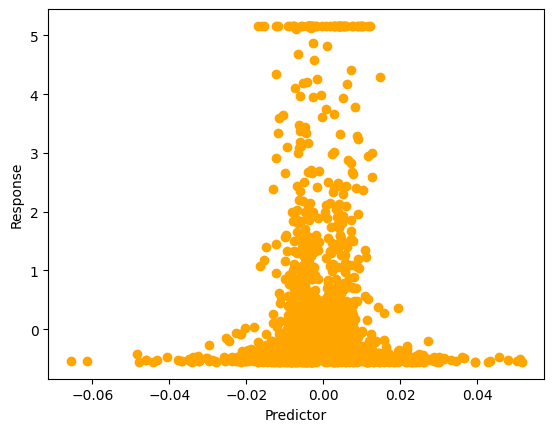

In [580]:
plt.scatter(working_df[[PREDICTOR_NAME]], response_column, color="orange")
plt.xlabel("Predictor")
plt.ylabel("Response")

#### Split data to train (80%) and test (20%)

In [581]:
# Build a train mask and test mask
np.random.seed(42)
data_size = working_df.shape[0]
testing_fraction = 0.2
testing_size = int(data_size * testing_fraction)

testing_indices = np.random.choice(np.arange(data_size), testing_size)
testing_mask = np.zeros(data_size, dtype = bool)
testing_mask[testing_indices] = True

training_mask = ~testing_mask # if testing_mask[i] = True, training_mask[i] = False

In [582]:
working_df['train_mask'] = training_mask
working_df['test_mask'] = testing_mask

In [583]:
training_condition = (working_df['train_mask'] == True)
training_df = working_df[training_condition][[PREDICTOR_NAME]].reset_index(drop=True)
training_target_series = working_df[training_condition][RESPONSE_NAME].reset_index(drop=True)
assert training_df.shape[0] == len(training_target_series)

training_df.head()

,rrirpnxm_nt_0
0,0.015402
1,-0.006332
2,0.001978
3,0.000035
4,0.004667


In [584]:
testing_condition = (working_df['test_mask'] == True)
testing_df = working_df[testing_condition][[PREDICTOR_NAME]].reset_index(drop=True)
testing_target_series = working_df[testing_condition][RESPONSE_NAME].reset_index(drop=True)
assert testing_df.shape[0] == len(testing_target_series)

testing_df.head()

,rrirpnxm_nt_0
0,0.005125
1,0.003413
2,-0.001960
3,-0.000405
4,-0.001259


#### Build a simple (1-variable) linear regression model

In [585]:
import sklearn.linear_model

simple_linreg = sklearn.linear_model.LinearRegression()
simple_linreg.fit(training_df, training_target_series) # Least Square Method
simple_linreg.coef_

array([1.3475641])

In [586]:
predicted_responses = simple_linreg.predict(testing_df)

#### View metric scores

In [587]:
from sklearn.metrics import mean_squared_error, r2_score

In [588]:
print("Mean squared error: %.3f" % mean_squared_error(testing_target_series, predicted_responses))

Mean squared error: 1.241


In [589]:
# Higher better. 1 is perfect prediction
print("Coefficient of determination: %3f" % r2_score(testing_target_series, predicted_responses))

Coefficient of determination: -0.007770


In [590]:
residuals = testing_target_series - predicted_responses

#### Check linear regression assumptions

##### Residuals must be normally distributed w/ Q-Q plot

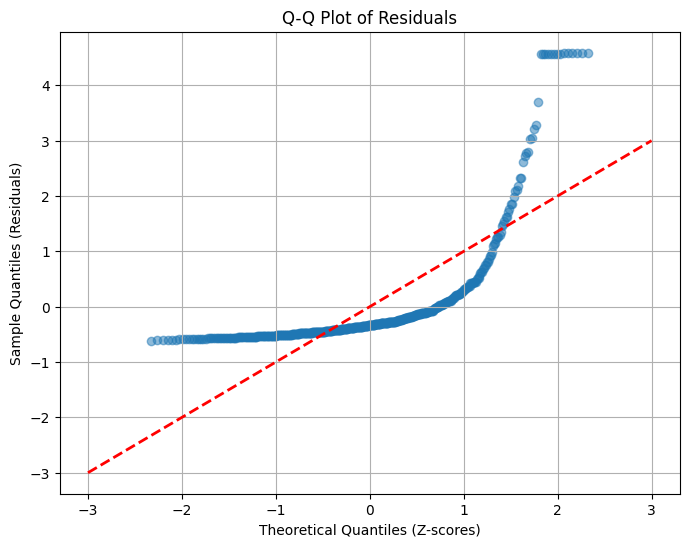

In [591]:
import scipy.stats as stats

sorted_residuals = np.sort(residuals)
z_score = (sorted_residuals - np.mean(sorted_residuals)) / np.std(sorted_residuals)
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(residuals)))

plt.figure(figsize=(8, 6))
plt.scatter(theoretical_quantiles, np.sort(z_score), alpha=0.5)
plt.xlabel('Theoretical Quantiles (Z-scores)')
plt.ylabel('Sample Quantiles (Residuals)')
plt.title('Q-Q Plot of Residuals')

plt.plot([-3, 3], [-3, 3], color='red', linestyle='--', linewidth=2) # Add a reference line
plt.grid()
plt.show()

In [592]:
helper.shapiro_test(residuals)

Shapiro-Wilk Test: Residuals NOT normally distributed.


##### Residuals have a fixed variance

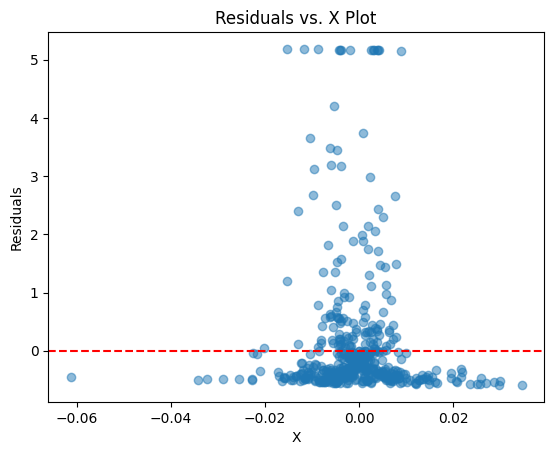

In [593]:
plt.scatter(testing_df, residuals, alpha=0.5)  # Replace X[:, 0] with the desired predictor variable
plt.xlabel('X')  # Replace 'X' with the label of the predictor variable
plt.ylabel('Residuals')
plt.title('Residuals vs. X Plot')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.show()

In [595]:
# White test if only use 1 predictor (simple linear regression)
# for multiple linear regression, use bp-test

helper.white_test(residuals, testing_df)

White Test: Residuals DO NOT have constant variance.
